# Unsupervised Learning - Autoencoders
by [David Ohm](http://ohmdsp.github.io/)
/ [GitHub](https://github.com/ohmdsp)

In this notebook, we will explore some neural networks for unsupervised learning. This will give us some tools to explore data in some very interesting ways.

Machine learning with deep neural networks can be classified into two categories:  (1) Unsupervised Learning - You have a lot of data and you want to learn something about the data (e.g., patterns, clustering, reduce dimensionality, generating new data, etc.), and (2) Supervised Learning - You know what you want to learn using your data and you have labeled training data.  We are going to explore the autoencoder.

## Autoencoders

![Autoencoder](images/autoencoder.png)

An autoencoder is a type of neural network that learns to encode a lower dimension representation of its input data.  It can also reproduce the original input data using a decoding process. An autoencoder does not require "labels" to learn.  Instead, it tries to generate an output that is the same as the input. For example, if an image is input, the output from the decoder will be the same image. In this notebook, we will see why this is interesting. 

It is worth mentioning two interesting practical applications of autoencoders: (1)data denoising, and (2)dimensionality reduction for data visualization. In many cases, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

In [1]:
# imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
# Some additional libraries to produce some visualizations for training
from PIL import Image
from libs.utils import montage
plt.style.use('ggplot')

import keras
from keras import layers
from keras.layers import Activation, Dense, Input, Lambda, Layer
from keras.layers import Conv2D, Flatten, MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy
from keras import backend as K
from keras import metrics

In [2]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

Let's load in some MNIST data to use for examples.

In [3]:
from keras.datasets import mnist

In [4]:
(x_train, _), (x_test, _) = mnist.load_data()

In [5]:
print(x_train.shape)

(60000, 28, 28)


In [6]:
# Select 1000 images from the training set for dispay
images = x_train[0:1000]

In [7]:
# Let's take a look at one of these images
img = x_train[0]

In [8]:
img.shape

(28, 28)

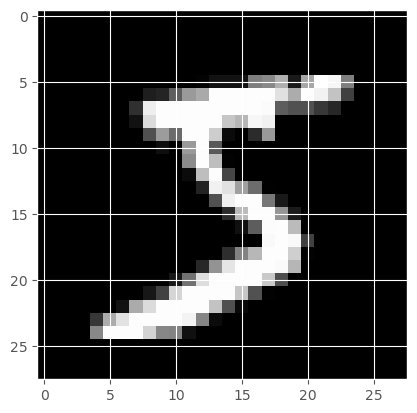

In [9]:
plt.imshow(img, cmap='gray')

Now, we can display a montage of the 1000 images from this training dataset.

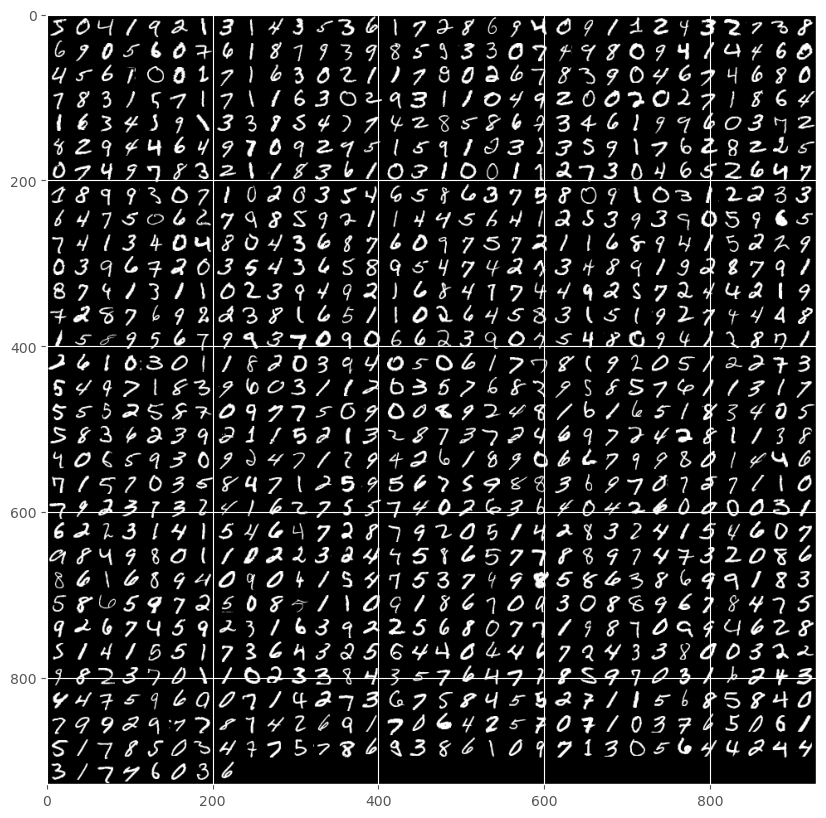

In [10]:
plt.rcParams["figure.figsize"] = (14,10)   # set plot sizes
# Then create a montage and draw the montage
plt.imshow(montage(images), cmap='gray')

Like we did in the preprocessing notebook, let's take a look at the mean of 1000 images from this dataset.

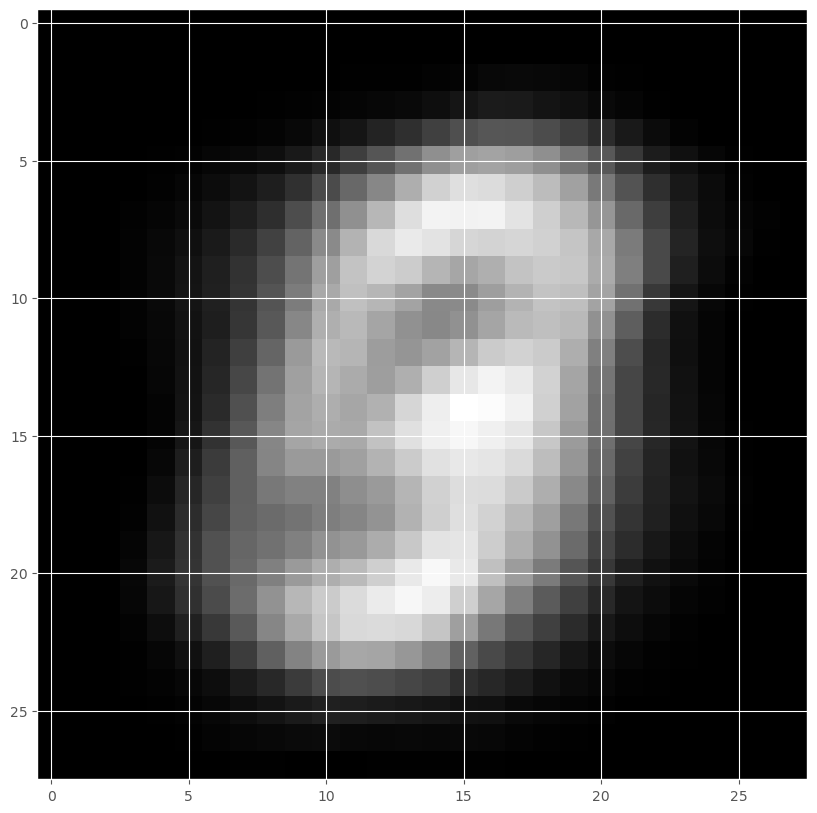

In [11]:
# Take the mean across all 1000 images
mean_img = np.mean(images, axis=0)

# Then plot the mean image.
plt.figure()
plt.imshow(mean_img.reshape((28, 28)), cmap='gray')


## Simple Autoencoder  - Fully Connected Model

We will start with the most basic autoencoder using a fully connected model.  From the original 784 (i.e., 28x28) neurons, we're going to reduce the image dimensions.

In [12]:
#Define the dimension to reduce the original image(s) to
encoding_dim = 32

In [13]:
# placeholder for input
input_img = keras.Input(shape = (784,))

In [14]:
# create autoencoder model
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(784, activation='sigmoid')(encoded)
autoencoder = keras.Model(input_img, decoded) 

In [15]:
# make seperate encoder model
encoder = keras.Model(input_img, encoded)

In [16]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [17]:
# configure the autoencoder model to use per-pixel crossentropy loss and an optimizer
autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0), loss='binary_crossentropy')
#autoencoder.compile(optimizer=tf.keras.optimizers.Adam(lr=.001), loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
# Create the data for training
x_train = x_train.astype('float32') / 255    # normalize images
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))       #flatten images to 1D
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [19]:
# Run the autoencoder training
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 2s 3ms/step - loss: 0.3571 - val_loss: 0.2699
Epoch 2/50
235/235 [==============================] - 0s 2ms/step - loss: 0.2617 - val_loss: 0.2498
Epoch 3/50
235/235 [==============================] - 0s 2ms/step - loss: 0.2393 - val_loss: 0.2271
Epoch 4/50
235/235 [==============================] - 0s 2ms/step - loss: 0.2200 - val_loss: 0.2107
Epoch 5/50
235/235 [==============================] - 0s 2ms/step - loss: 0.2060 - val_loss: 0.1987
Epoch 6/50
235/235 [==============================] - 0s 2ms/step - loss: 0.1952 - val_loss: 0.1892
Epoch 7/50
235/235 [==============================] - 0s 2ms/step - loss: 0.1865 - val_loss: 0.1815
Epoch 8/50
235/235 [==============================] - 0s 2ms/step - loss: 0.1795 - val_loss: 0.1749
Epoch 9/50
235/235 [==============================] - 0s 2ms/step - loss: 0.1735 - val_loss: 0.1697
Epoch 10/50
235/235 [==============================] - 0s 2ms/step - loss: 0.1683 - val_loss: 0.1649

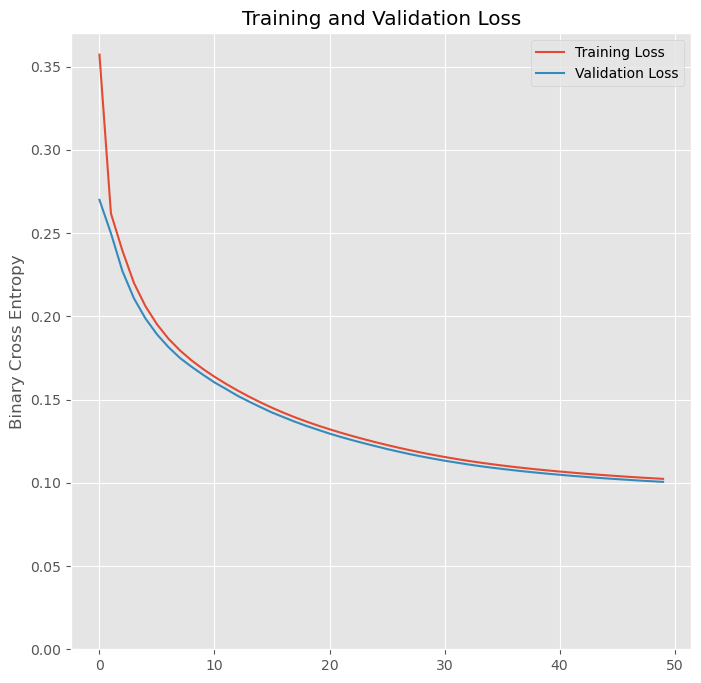

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# Create seperate decoder model
# create a placeholder for an encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [22]:
#encode and decode some digits. Note: we use images from the test dataset
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
#encoder_imgs = encoder.predict(x_test)

313/313 [==============================] - 0s 407us/step


In [23]:
print(decoded_imgs.shape)

(10000, 784)


In [24]:
decoded_imgs.mean()

0.13239305

Let's compare some input images to their output images from the autoencoder. You will see that the image reconstruction is not very good. 

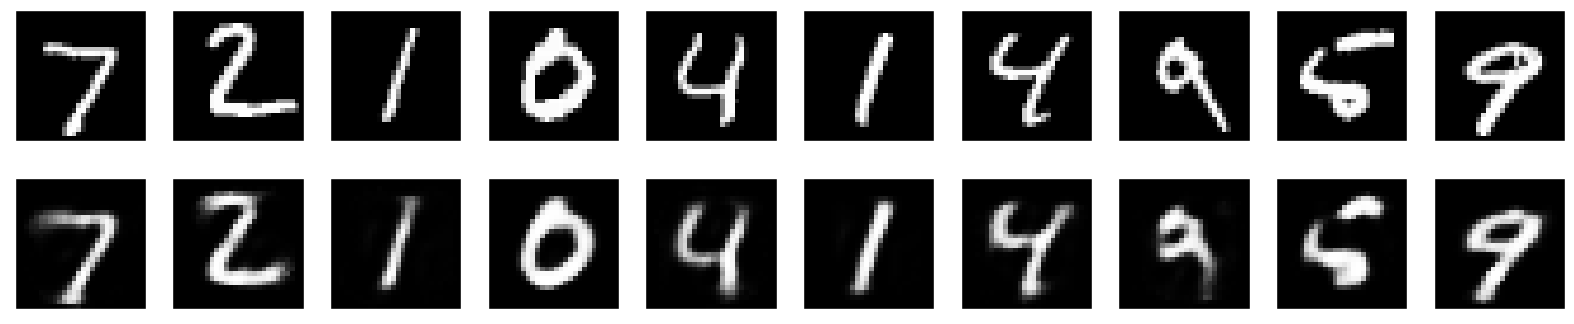

In [25]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

So far, the latent representations of our input images have been constrained by the size of the hidden layer of 32. With a simple neural network like this, the hidden layer is learning an approximation of PCA (principal component analysis). 

Another way we can  constrain the representations to be small (e.g., compressed) is to add a sparsity contraint on the activation function of the hidden layer, so fewer neurons will "fire" each computation. In Keras, this can be done by adding an activity_regularizer to our Dense layer (see next cell). We will not explore this here, but you can experiment on your own.

In [26]:
# add a Dense layer with a L1 activity regularizer
#encoded = Dense(encoding_dim, activation='relu',
#                activity_regularizer=regularizers.l1(10e-5))(input_img)

## Deep Autonencoder

We are not limited to a single layer in the encoder. We could add a stack of layers - making the network deeper.

In [27]:
#clear the previous model
tf.compat.v1.reset_default_graph()

In [28]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [29]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1.0), loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136

c:\Users\ohmds\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adadelta.py:79: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [30]:
history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
235/235 [==============================] - 1s 3ms/step - loss: 0.3355 - val_loss: 0.2633
Epoch 2/20
235/235 [==============================] - 1s 2ms/step - loss: 0.2581 - val_loss: 0.2535
Epoch 3/20
235/235 [==============================] - 1s 2ms/step - loss: 0.2449 - val_loss: 0.2361
Epoch 4/20
235/235 [==============================] - 1s 2ms/step - loss: 0.2285 - val_loss: 0.2222
Epoch 5/20
235/235 [==============================] - 1s 2ms/step - loss: 0.2211 - val_loss: 0.2151
Epoch 6/20
235/235 [==============================] - 1s 2ms/step - loss: 0.2091 - val_loss: 0.2009
Epoch 7/20
235/235 [==============================] - 1s 2ms/step - loss: 0.1969 - val_loss: 0.1918
Epoch 8/20
235/235 [==============================] - 1s 2ms/step - loss: 0.1877 - val_loss: 0.1840
Epoch 9/20
235/235 [==============================] - 1s 2ms/step - loss: 0.1813 - val_loss: 0.1785
Epoch 10/20
235/235 [==============================] - 1s 2ms/step - loss: 0.1764 - val_loss: 0.1728

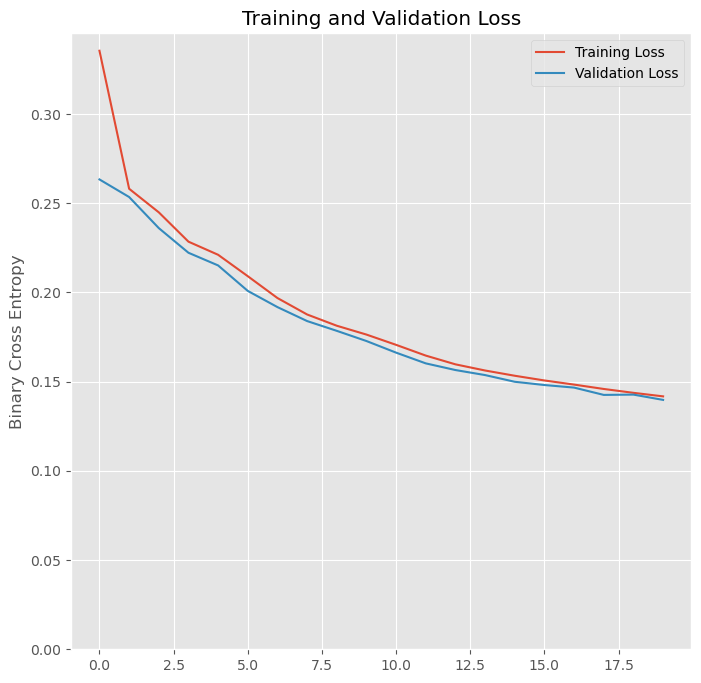

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [32]:
#encode and decode some digits from test set
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 0s 638us/step


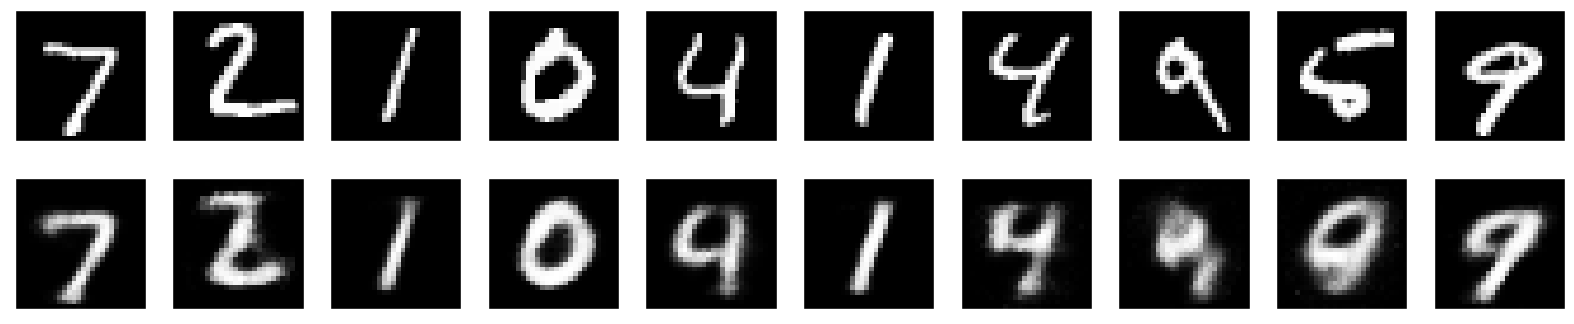

In [33]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The deeper model looks to generate similar results, but it is not a dramatic improvement over the simple model. Let's look at using convolutional layers.

## Convolutional Autoencoder
Since our inputs are images, it makes sense to use convolutional neural networks as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders -- they simply perform much better.

Let's implement a convolutional autoencoder to see how it performs. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [34]:
#clear the previous model
tf.compat.v1.reset_default_graph()

In [35]:
input_img = Input(shape=(28, 28, 1))

In [36]:
# Define our encoder network
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

In [37]:
# Define our decoder network
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [38]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1.0), loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584   

In [39]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [40]:
#from keras.callbacks import TensorBoard

history = autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/20
469/469 [==============================] - 5s 5ms/step - loss: 0.2108 - val_loss: 0.1691
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1611 - val_loss: 0.1494
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1445 - val_loss: 0.1361
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1347 - val_loss: 0.1276
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1291 - val_loss: 0.1280
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1252 - val_loss: 0.1200
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1223 - val_loss: 0.1222
Epoch 8/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1197 - val_loss: 0.1169
Epoch 9/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1178 - val_loss: 0.1130
Epoch 10/20
469/469 [==============================] - 2s 4ms/step - loss: 0.1162 - val_loss: 0.1142

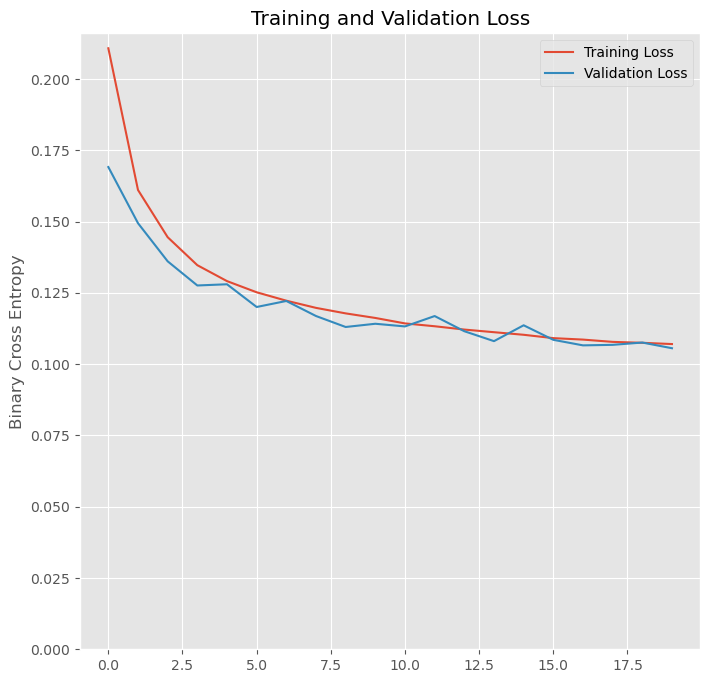

In [41]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [42]:
#encode and decode some digits from test set
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 0s 835us/step


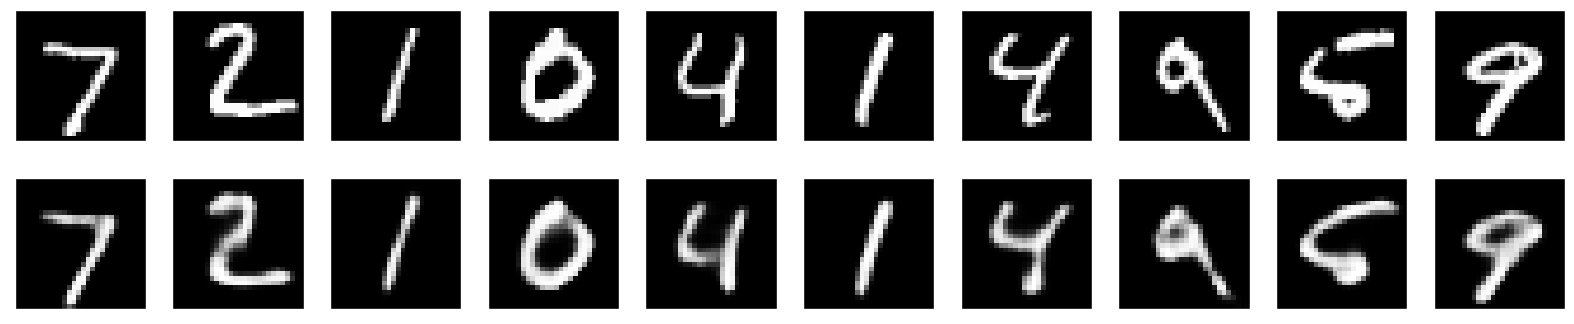

In [43]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The results from the convolutional autoencoder are better. It is especially apparent with the 9 and 2 digits.

We can also look at the encoded representations. These are shaped as 8x4x4 so we need to reshape them to 4x32 to display.

In [44]:
# create seperate encoder model
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

313/313 [==============================] - 0s 550us/step


In [45]:
encoded_imgs[0].shape

(4, 4, 8)

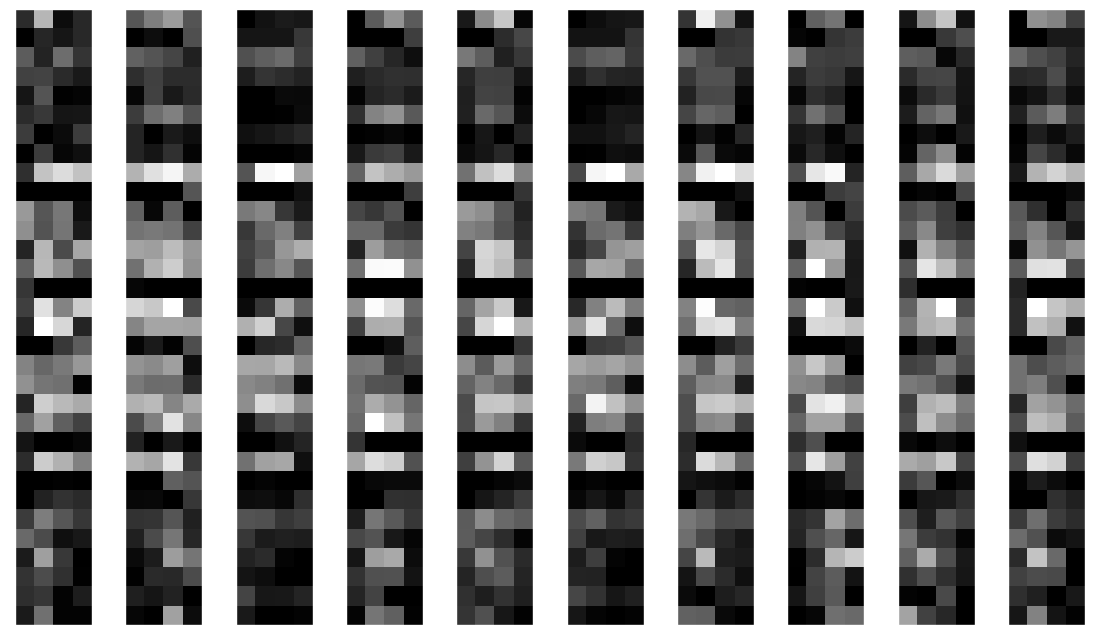

In [46]:
n = 10
plt.figure(figsize=(14, 8))
for i in range(n):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


## Denoising Autoencoder

The denoising autoencoder is a very simple extension to an autoencoder, and it can be a useful tool in the hands of a signal processing engineer.  We will use an convolutional autoencoder to work on a toy image denoising problem. We will train the autoencoder to map noisy digits images to clean digits images. Note - we will simulate the noisy data by adding noise to images from the MNIST dataset.

In [47]:
#clear the previous model
tf.compat.v1.reset_default_graph()

In [48]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [49]:
# Generate noisy MNIST images by adding noise with normal dist centered at 0.5 and variance of 0.5
noise = np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy = x_train + 0.5*noise
noise = np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy = x_test + 0.5*noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Let's look at some of the noisy digits:

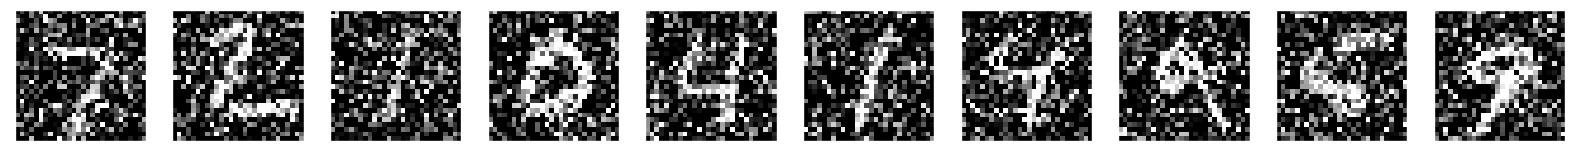

In [50]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We will use a slightly different model for denoising that has more filters per layer.

In [51]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [52]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1.0), loss='binary_crossentropy')

In [53]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248  

In [54]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/25
469/469 [==============================] - 3s 6ms/step - loss: 0.1717 - val_loss: 0.1231
Epoch 2/25
469/469 [==============================] - 3s 5ms/step - loss: 0.1194 - val_loss: 0.1167
Epoch 3/25
469/469 [==============================] - 3s 5ms/step - loss: 0.1118 - val_loss: 0.1068
Epoch 4/25
469/469 [==============================] - 3s 5ms/step - loss: 0.1081 - val_loss: 0.1039
Epoch 5/25
469/469 [==============================] - 3s 5ms/step - loss: 0.1057 - val_loss: 0.1023
Epoch 6/25
469/469 [==============================] - 3s 5ms/step - loss: 0.1044 - val_loss: 0.1024
Epoch 7/25
469/469 [==============================] - 3s 6ms/step - loss: 0.1031 - val_loss: 0.1029
Epoch 8/25
469/469 [==============================] - 3s 6ms/step - loss: 0.1023 - val_loss: 0.1013
Epoch 9/25
469/469 [==============================] - 3s 6ms/step - loss: 0.1015 - val_loss: 0.1000
Epoch 10/25
469/469 [==============================] - 3s 6ms/step - loss: 0.1012 - val_loss: 0.1004

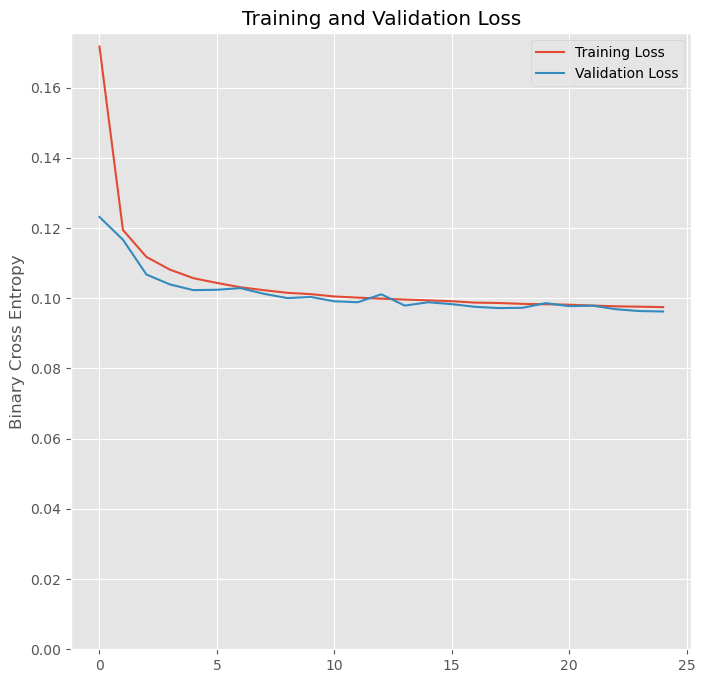

In [55]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [56]:
# Predict the Autoencoder output from corrupted test images
decoded_imgs = autoencoder.predict(x_test_noisy)

313/313 [==============================] - 0s 887us/step


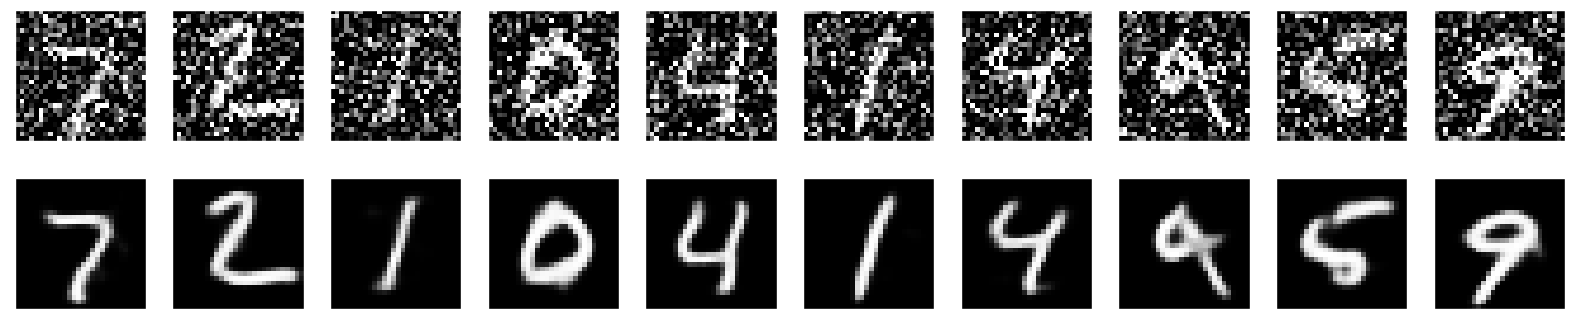

In [57]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational Autoencoder (VAE)

A variational autoencoder is a type of autoencoder with constraints on the encoded representations that can be learned. It learns a latent variable model for the input data. So, instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution for modeling your data. If you sample points from this distribution, you can generate new input data samples. For this reason a VAE is considered a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma (i.e., the mean and log of variance for a normal distribution). Then, we randomly sample points z from that latent normal distribution, using z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal distribution. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the nearal network are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. It is not required to use the KL term, although it helps in learning well-formed latent spaces and reducing overfitting to the training data.

Let's make one!

In [58]:
#clear the previous model
tf.compat.v1.reset_default_graph()

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [59]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [60]:
x_train.shape

(60000, 784)

In [61]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [62]:
# VAE model = encoder + decoder
input_shape = (original_dim, )
latent_dim = 2
intermediate_dim = 512
batch_size = 100
epochs = 50

x = keras.Input(shape = (original_dim,))
h = layers.Dense(intermediate_dim, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(h)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)
z = Sampling()([z_mean, z_log_var])


decoder_h = layers.Dense(intermediate_dim, activation="relu")
decoder_mean = layers.Dense(original_dim, activation="sigmoid")
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

#vae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
#vae_encoder.summary()

In [63]:
# Custom Loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
    
    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs = inputs)
        return x        

In [64]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = keras.Model(x, y)
vae.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=.001), loss = None)
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          401920      ['input_1[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['dense[0][0]']                  
                                                                                              

### We can create an anomoly
For fun and exploration, let's remove a digit from the dataset to simulate an anomoly. We can explore methods for anomoly detection later.

In [65]:
anomalous_digit = 8

In [66]:
# remove anomalous digit from train data
train_mask = np.where(y_train!=anomalous_digit)[0]
x_train = x_train[train_mask, :]
y_train = y_train[train_mask]

# create binary labels
test_mask = np.where(y_test != anomalous_digit)[0]
y_test_binary = np.zeros(y_test.shape[0])
y_test_binary[test_mask] = 1

In [67]:
history = vae.fit(x_train,
        shuffle=True,
        epochs=10,
        batch_size=100)

Train on 54149 samples
Epoch 1/10
54149/54149 [==============================] - 2s 32us/sample - loss: 184.5935
Epoch 2/10
54149/54149 [==============================] - 1s 25us/sample - loss: 166.3263
Epoch 3/10
54149/54149 [==============================] - 1s 25us/sample - loss: 162.8543
Epoch 4/10
54149/54149 [==============================] - 1s 25us/sample - loss: 160.7628
Epoch 5/10
54149/54149 [==============================] - 1s 24us/sample - loss: 159.2587
Epoch 6/10
54149/54149 [==============================] - 1s 25us/sample - loss: 157.9818
Epoch 7/10
54149/54149 [==============================] - 1s 25us/sample - loss: 156.8933
Epoch 8/10
54149/54149 [==============================] - 1s 25us/sample - loss: 155.9559
Epoch 9/10
54149/54149 [==============================] - 1s 25us/sample - loss: 155.1453
Epoch 10/10
54149/54149 [==============================] - 1s 24us/sample - loss: 154.4524


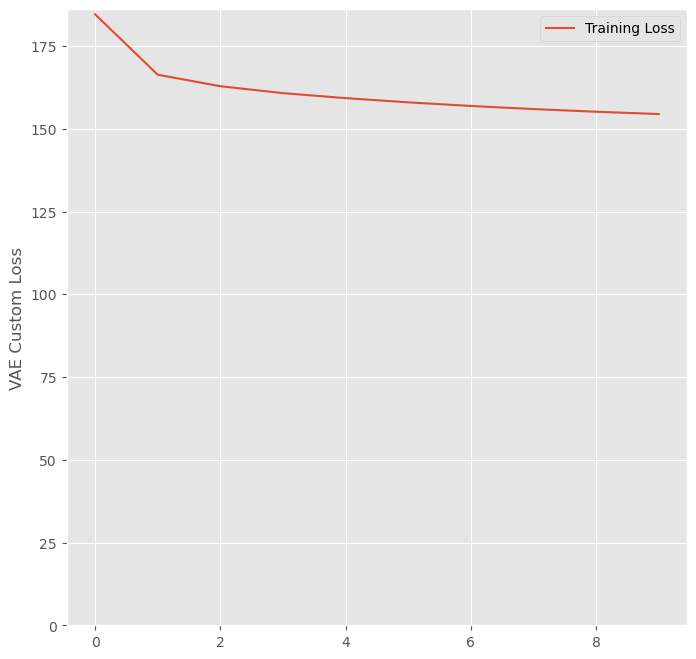

In [68]:
loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('VAE Custom Loss')
plt.ylim([0,max(plt.ylim())])
#plt.title('Training and Validation Loss')
plt.show()

## Visualize the Learned Latent Distribution

A variational autoencoder allows us to inspect the latent space to learn more about our model and our data.  For example, in anomaly detection, latent variables can be used to try and determine the cause of anomalies.  
In the case that we have 2 latent dimensions we can easily visualize the representation.  With higher dimensionality we can use dimensionality reducing techniques such as PCA or t-SNE to visualize.

In [69]:
# build a model to project inputs on to the latent space
encoder = Model(x, z_mean)

c:\Users\ohmds\anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


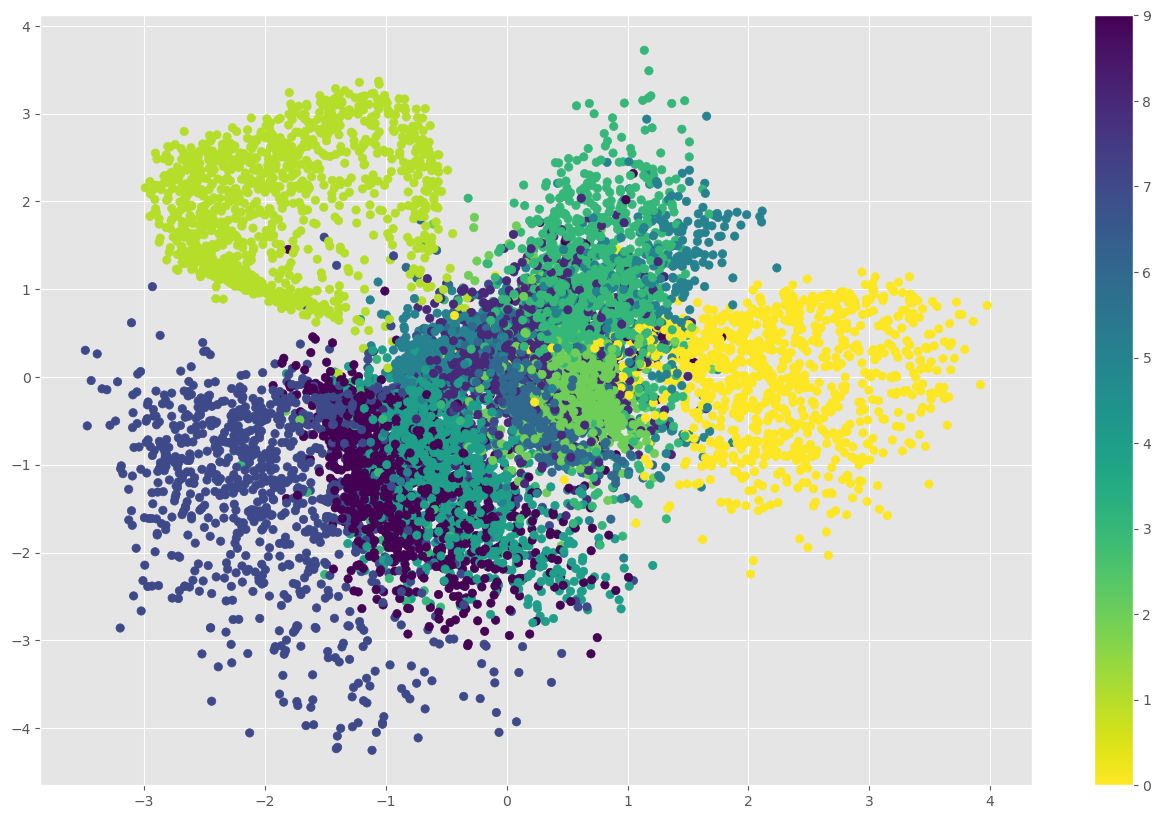

In [70]:
if latent_dim == 2:
    # display a 2D plot of the digit classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(16, 10))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis_r')
    plt.colorbar()
    plt.show()

In [71]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536      
                                                                 
 dense_2 (Dense)             (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


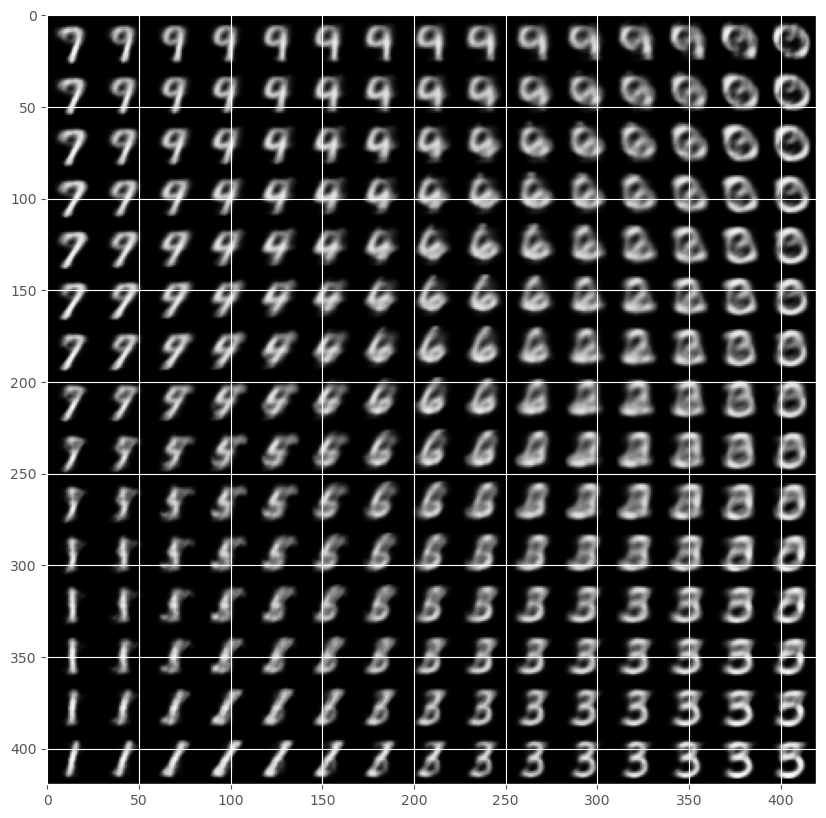

In [72]:
# display a 2D manifold of the digits
from scipy.stats import norm
epsilon_std = 1
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit       
        
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## Anomaly Detection

We detect anomalies by computing the probability that our reconstructed datapoint came from the ground truth.  To do this, we reconstruct (run through autoencoder) all of the data in our test set and then compute the binary cross-entropy between ground truth digits and our reconstruction.  

In [73]:
# compute sigmoid output of the autoencoder (without variational parts)
sigmoid_output = Model(x, x_decoded_mean)

In [74]:
# compute reconstructions of the test set
x_test_recons = sigmoid_output.predict(x_test)

To get the likelihood of our reconstruction we compute exponential of the negative cross-entropy.

In [75]:
def recon_prob(output, target):
    xent = -(target*np.log(output + .0000001) + (1.0 - target) * np.log(1.0 - output + .0000001))
    xent = np.mean(xent, axis=1)
    return np.exp(-xent)

probs = recon_prob(x_test_recons, x_test)

We can learn about the effectiveness of our anomaly detector by visualizing the results.  Below we randomly sample ten images at a time from the test set, then display the original image with the output reconstruction.

image index: 5607 normal: 1.0 probability: 0.84647876
image index: 1166 normal: 1.0 probability: 0.82839787
image index: 2383 normal: 1.0 probability: 0.849948
image index: 936 normal: 0.0 probability: 0.7609215
image index: 3176 normal: 1.0 probability: 0.7838407
image index: 7408 normal: 1.0 probability: 0.8290555
image index: 253 normal: 1.0 probability: 0.837824
image index: 1483 normal: 1.0 probability: 0.9309929
image index: 8501 normal: 1.0 probability: 0.8092555
image index: 3384 normal: 1.0 probability: 0.75114816


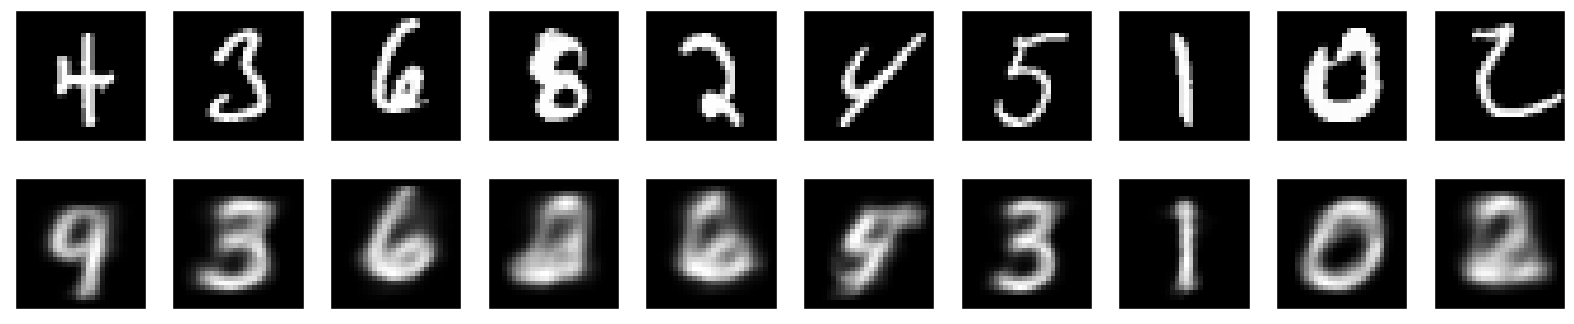

In [76]:
# plot original digit, reconstruction, and probability
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    img_idx = np.random.randint(0,y_test.shape[0])
    print('image index: ' + str(img_idx) +
          ' normal: ' + str(y_test_binary[img_idx]) + 
          ' probability: ' + str(probs[img_idx]))
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_recons[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It can be instructive to visualize what are the most normal images in our test set according to the model.

image index: 672 normal: 1.0 probability: 0.9547681
image index: 754 normal: 1.0 probability: 0.9559652
image index: 8724 normal: 1.0 probability: 0.9575669
image index: 2283 normal: 1.0 probability: 0.9569907
image index: 5902 normal: 1.0 probability: 0.9554225
image index: 9345 normal: 1.0 probability: 0.9570419
image index: 1897 normal: 1.0 probability: 0.95442027
image index: 2357 normal: 1.0 probability: 0.9540411
image index: 1295 normal: 1.0 probability: 0.9538429
image index: 3562 normal: 1.0 probability: 0.9538402


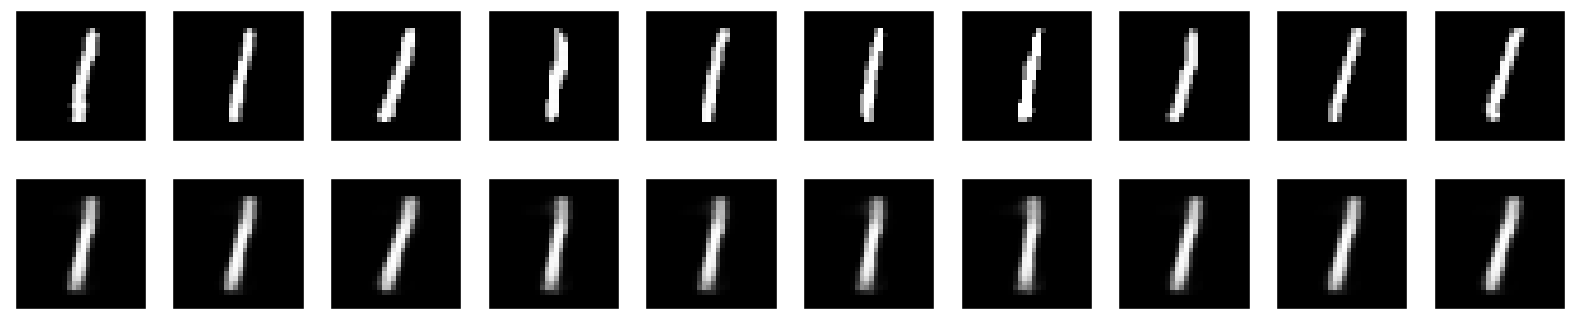

In [77]:
# plot n highest probability reconstructions
n = 10
ten_highest = np.argpartition(-probs, n)
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    img_idx = ten_highest[i-1]
    print('image index: ' + str(img_idx) +
          ' normal: ' + str(y_test_binary[img_idx]) + 
          ' probability: ' + str(probs[img_idx]))
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_recons[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

It's also helpful to visualize what are the most anomalous images according to our model.

image index: 8186 normal: 1.0 probability: 0.59884536
image index: 8015 normal: 0.0 probability: 0.5978918
image index: 9596 normal: 0.0 probability: 0.613725
image index: 7926 normal: 0.0 probability: 0.63134676
image index: 4637 normal: 1.0 probability: 0.6326575
image index: 8266 normal: 0.0 probability: 0.63221985
image index: 2044 normal: 1.0 probability: 0.6333411
image index: 9078 normal: 0.0 probability: 0.635207
image index: 9634 normal: 1.0 probability: 0.636594
image index: 7117 normal: 1.0 probability: 0.63674045


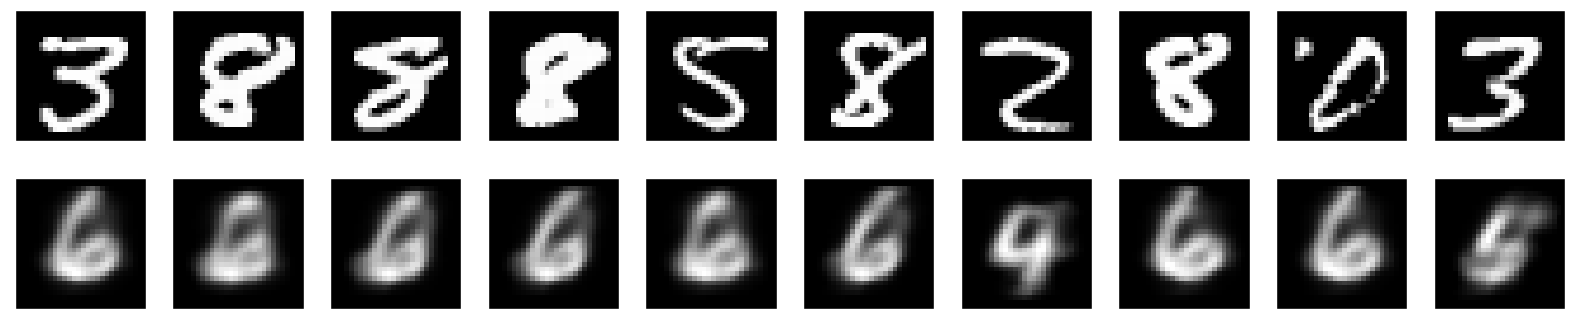

In [78]:
# plot n lowest probability reconstructions
n = 10
ten_highest = np.argpartition(probs, n)
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    img_idx = ten_highest[i-1]
    print('image index: ' + str(img_idx) +
          ' normal: ' + str(y_test_binary[img_idx]) + 
          ' probability: ' + str(probs[img_idx]))
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test_recons[img_idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

__Question__: what can you say about the probabilities of your most anomalous digits?

__Try This__: Change the anomalous digit and retrain the model.  Is the anomaly detection model effective for digit?

__Try This__: Retrain the VAE without removing an anomalous digit. What do you notice about the images that are found to be anomalous?

## Model Evaluation

To evaluate the effectiveness of the model, we can use a ROC curve and compute the AUC (area-under-the-curve).  A diagonal line represents the performance similar to random chance (i.e., flipping a coin).  A quickly rising ROC curve indicates a well performing model.  Similarly, an AUC of .5 means random chance and a quickly rising AUC means the model is performing well.

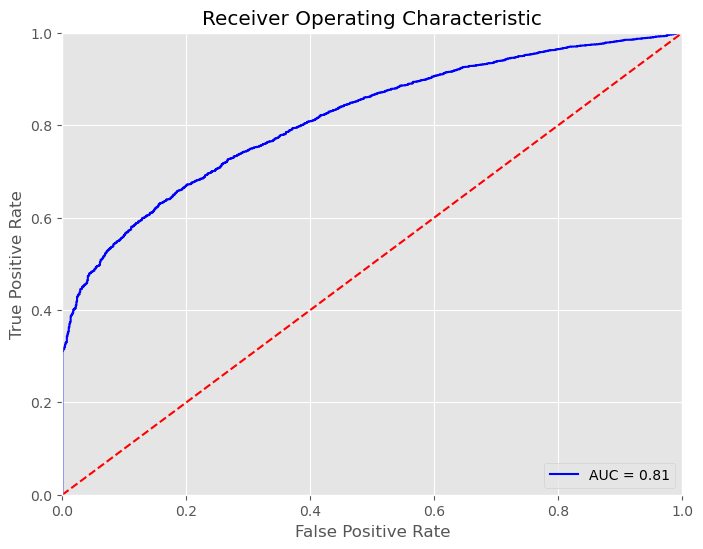

In [79]:
# compute the ROC curves
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

auc = roc_auc_score(y_test_binary, probs)
fpr, tpr, thresholds = roc_curve(y_test_binary, probs)

plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

__Question__: How does the anomolous digit affect the AUC after retraining?

Since we learned the distribution underlying our data using the VAE, we can repeatedly sample the distribution to generate more data.  The more we sample, the lower variance our probability estimate will have due to averaging.

In [80]:
# compute reconstruction probabilities with lower variance. Note: this takes some time to compute.
num_samples = 100
all_probs = np.zeros((x_test.shape[0], num_samples))
for i in range(num_samples):
    
    x_test_recons = sigmoid_output.predict(x_test)
    
    probs = recon_prob(x_test_recons, x_test)

    all_probs[:, i] = probs

In [81]:
mean_probs = np.mean(all_probs, axis=1)

auc with sampling: 0.8160194073156672
auc: 0.8135405998004397


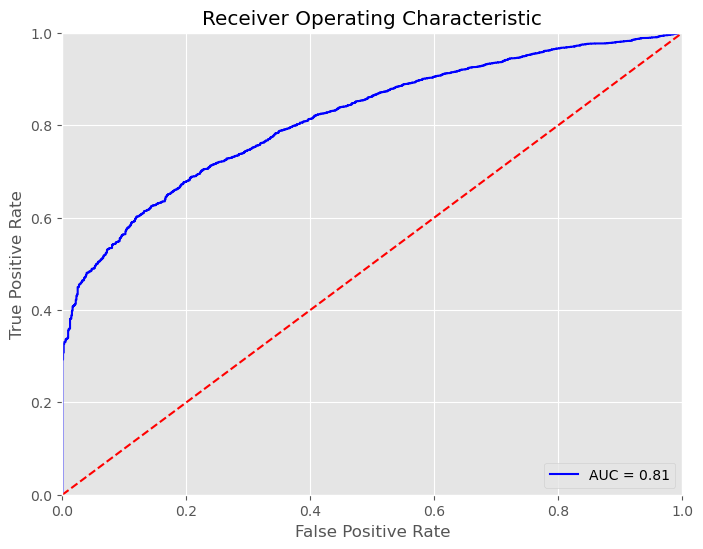

In [82]:
auc_with_sampling = roc_auc_score(y_test_binary, mean_probs)
print('auc with sampling: ' + str(auc_with_sampling))
print('auc: ' + str(auc))

fpr, tpr, thresholds = roc_curve(y_test_binary, mean_probs)

plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

As you can see, for this example there is not much difference in the ROC from generating more data. 